In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM,GRU

In [214]:
df = pd.read_csv('./data.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.drop(['new_confirmed_cases', 'new_deaths'], axis=1)
df.tail()

,NO2,CO,PM25,OZONE,PM10,NO,7_day_avg_new_cases,7_day_avg_new_deaths
Date,,,,,,,,
2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049,1124.714286,15.571429
2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054,1075.571429,14.714286
2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034,1069.142857,15.285714
2020-10-17,0.025,0.6520,19.1,0.047,41.2,0.014,1038.428571,16.428571
2020-10-18,0.018,0.5370,24.9,0.048,40.8,0.006,996.428571,13.428571


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 267 entries, 2020-01-26 to 2020-10-18
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NO2                   267 non-null    float64
 1   CO                    267 non-null    float64
 2   PM25                  267 non-null    float64
 3   OZONE                 267 non-null    float64
 4   PM10                  267 non-null    float64
 5   NO                    267 non-null    float64
 6   7_day_avg_new_cases   267 non-null    float64
 7   7_day_avg_new_deaths  267 non-null    float64
dtypes: float64(8)
memory usage: 18.8 KB


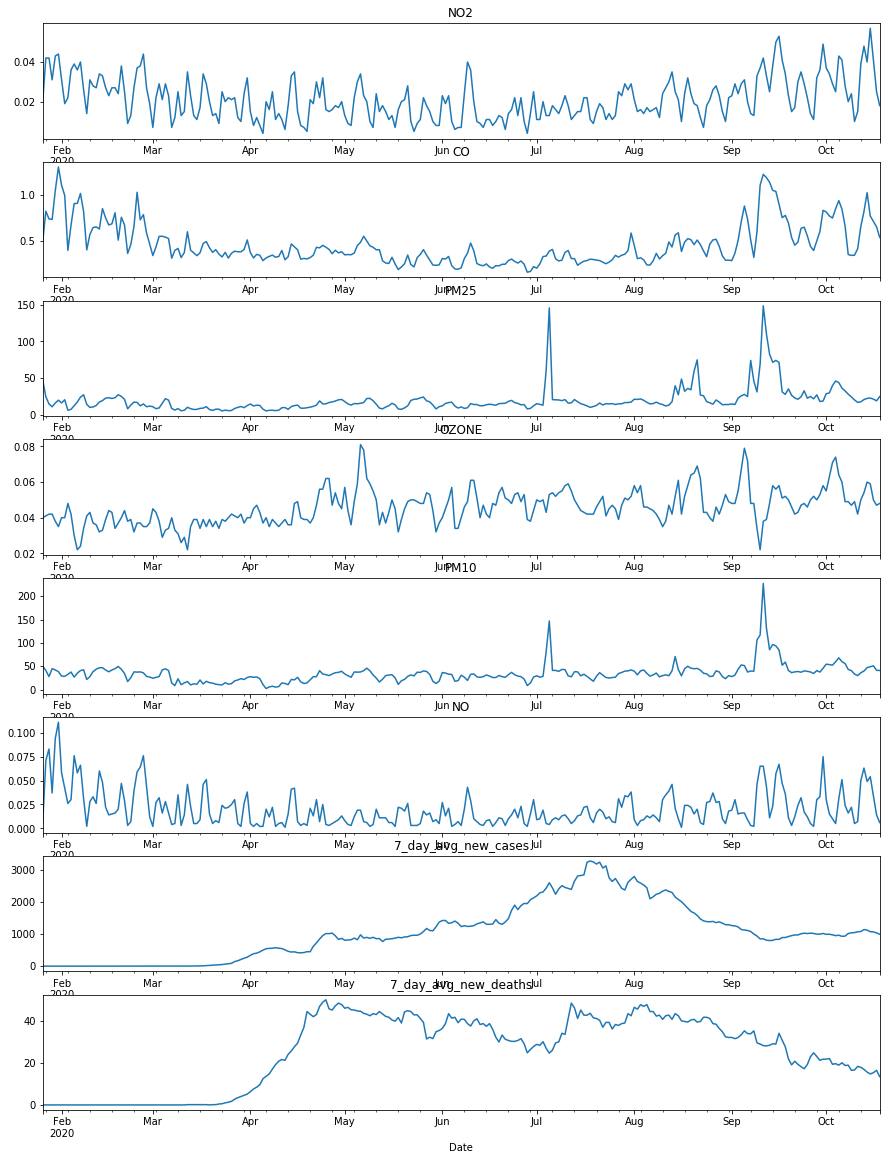

In [6]:
fig,ax = plt.subplots(8,1,figsize=(15,20))
for i,column in enumerate([col for col in df.columns]):
    df[column].plot(ax=ax[i])
    ax[i].set_title(column)

In [206]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def training(trainX, trainY, testX, testY):
    stop_noimprovement = EarlyStopping(patience=10)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1],trainX.shape[2]), dropout=0.2))
    model.add(Dense(2))
    model.compile(loss="mse",optimizer="adam")
    history = model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,verbose=2,callbacks=[stop_noimprovement],shuffle=False)
    return history, model

def prediction(model, testX, testY):
    predicted = model.predict(testX)
    testXRe = testX.reshape(testX.shape[0],testX.shape[2])
    predicted = np.concatenate((testXRe[:,:-2], predicted),axis=1)
    predicted = scaler.inverse_transform(predicted[:,-8:])
    forecast_df = pd.DataFrame(predicted, columns=df.columns)
    forecast_df = forecast_df[['7_day_avg_new_cases', '7_day_avg_new_deaths']]
    new_cases_rmse = np.sqrt(mean_squared_error(testY[:,-2],predicted[:,-2]))
    new_deaths_rmse = np.sqrt(mean_squared_error(testY[:,-1],predicted[:,-1]))
    return new_cases_rmse, new_deaths_rmse
    
def plots(histories):
    
    fig = plt.figure(figsize=(20,50))
    for ((history, _), i) in zip(histories, range(1,len(histories) + 1)):
        plt.subplot(len(histories),2,i)
        plt.title(f'Training for {i} input days')
        plt.plot(history.history['loss'],label='train')
        plt.plot(history.history['val_loss'],label='test')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [207]:
values = df.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1,1))
scaled = scaler.fit_transform(values)

In [208]:
n_train = int(len(df)*.8)

histories = []
predictions = []

for i in range(1,22):
    print(f'***** Training for {i} input days *****')
    reframed = series_to_supervised(scaled,i,1)
    reframed.drop(reframed.columns[[-3,-4,-5,-6,-7,-8]], axis=1, inplace=True)
    values = reframed.values
    train = values[:n_train]
    test = values[n_train:]
    trainX,trainY = train[:,:-2],train[:,-2:]
    testX,testY = test[:,:-2],test[:,-2:]
    trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
    testX = testX.reshape(testX.shape[0],1,testX.shape[1])
    
    history, model = training(trainX, trainY, testX, testY)
    histories.append((history, model))
    
    cases_rmse, deaths_rmse = prediction(model, testX, testY)
    predictions.append((cases_rmse, deaths_rmse))

***** Training for 1 input days *****
Train on 213 samples, validate on 53 samples
Epoch 1/100
213/213 - 2s - loss: 0.5253 - val_loss: 0.1028
Epoch 2/100
213/213 - 0s - loss: 0.4972 - val_loss: 0.0956
Epoch 3/100
213/213 - 0s - loss: 0.4745 - val_loss: 0.0890
Epoch 4/100
213/213 - 0s - loss: 0.4534 - val_loss: 0.0829
Epoch 5/100
213/213 - 0s - loss: 0.4380 - val_loss: 0.0772
Epoch 6/100
213/213 - 0s - loss: 0.4063 - val_loss: 0.0718
Epoch 7/100
213/213 - 0s - loss: 0.3936 - val_loss: 0.0666
Epoch 8/100
213/213 - 0s - loss: 0.3697 - val_loss: 0.0617
Epoch 9/100
213/213 - 0s - loss: 0.3539 - val_loss: 0.0571
Epoch 10/100
213/213 - 0s - loss: 0.3322 - val_loss: 0.0528
Epoch 11/100
213/213 - 0s - loss: 0.3143 - val_loss: 0.0489
Epoch 12/100
213/213 - 0s - loss: 0.2844 - val_loss: 0.0455
Epoch 13/100
213/213 - 0s - loss: 0.2760 - val_loss: 0.0423
Epoch 14/100
213/213 - 0s - loss: 0.2564 - val_loss: 0.0394
Epoch 15/100
213/213 - 0s - loss: 0.2377 - val_loss: 0.0370
Epoch 16/100
213/213 - 0s 

213/213 - 0s - loss: 0.0503 - val_loss: 0.0217
Epoch 36/100
213/213 - 0s - loss: 0.0481 - val_loss: 0.0210
Epoch 37/100
213/213 - 0s - loss: 0.0430 - val_loss: 0.0206
Epoch 38/100
213/213 - 0s - loss: 0.0371 - val_loss: 0.0208
Epoch 39/100
213/213 - 0s - loss: 0.0548 - val_loss: 0.0209
Epoch 40/100
213/213 - 0s - loss: 0.0538 - val_loss: 0.0205
Epoch 41/100
213/213 - 0s - loss: 0.0451 - val_loss: 0.0202
Epoch 42/100
213/213 - 0s - loss: 0.0468 - val_loss: 0.0199
Epoch 43/100
213/213 - 0s - loss: 0.0434 - val_loss: 0.0198
Epoch 44/100
213/213 - 0s - loss: 0.0483 - val_loss: 0.0202
Epoch 45/100
213/213 - 0s - loss: 0.0465 - val_loss: 0.0202
Epoch 46/100
213/213 - 0s - loss: 0.0470 - val_loss: 0.0195
Epoch 47/100
213/213 - 0s - loss: 0.0509 - val_loss: 0.0195
Epoch 48/100
213/213 - 0s - loss: 0.0482 - val_loss: 0.0196
Epoch 49/100
213/213 - 0s - loss: 0.0519 - val_loss: 0.0198
Epoch 50/100
213/213 - 0s - loss: 0.0464 - val_loss: 0.0197
Epoch 51/100
213/213 - 0s - loss: 0.0471 - val_loss: 

Epoch 7/100
213/213 - 0s - loss: 0.1404 - val_loss: 0.0415
Epoch 8/100
213/213 - 0s - loss: 0.1117 - val_loss: 0.0396
Epoch 9/100
213/213 - 0s - loss: 0.0873 - val_loss: 0.0377
Epoch 10/100
213/213 - 0s - loss: 0.0696 - val_loss: 0.0364
Epoch 11/100
213/213 - 0s - loss: 0.0649 - val_loss: 0.0348
Epoch 12/100
213/213 - 0s - loss: 0.0580 - val_loss: 0.0339
Epoch 13/100
213/213 - 0s - loss: 0.0597 - val_loss: 0.0337
Epoch 14/100
213/213 - 0s - loss: 0.0558 - val_loss: 0.0346
Epoch 15/100
213/213 - 0s - loss: 0.0516 - val_loss: 0.0342
Epoch 16/100
213/213 - 0s - loss: 0.0487 - val_loss: 0.0322
Epoch 17/100
213/213 - 0s - loss: 0.0485 - val_loss: 0.0310
Epoch 18/100
213/213 - 0s - loss: 0.0450 - val_loss: 0.0293
Epoch 19/100
213/213 - 0s - loss: 0.0434 - val_loss: 0.0283
Epoch 20/100
213/213 - 0s - loss: 0.0462 - val_loss: 0.0289
Epoch 21/100
213/213 - 0s - loss: 0.0525 - val_loss: 0.0292
Epoch 22/100
213/213 - 0s - loss: 0.0435 - val_loss: 0.0296
Epoch 23/100
213/213 - 0s - loss: 0.0373 - 

213/213 - 0s - loss: 0.0353 - val_loss: 0.0227
Epoch 23/100
213/213 - 0s - loss: 0.0291 - val_loss: 0.0226
Epoch 24/100
213/213 - 0s - loss: 0.0315 - val_loss: 0.0206
Epoch 25/100
213/213 - 0s - loss: 0.0336 - val_loss: 0.0205
Epoch 26/100
213/213 - 0s - loss: 0.0361 - val_loss: 0.0200
Epoch 27/100
213/213 - 0s - loss: 0.0285 - val_loss: 0.0198
Epoch 28/100
213/213 - 0s - loss: 0.0335 - val_loss: 0.0188
Epoch 29/100
213/213 - 0s - loss: 0.0300 - val_loss: 0.0202
Epoch 30/100
213/213 - 0s - loss: 0.0313 - val_loss: 0.0200
Epoch 31/100
213/213 - 0s - loss: 0.0330 - val_loss: 0.0178
Epoch 32/100
213/213 - 0s - loss: 0.0330 - val_loss: 0.0180
Epoch 33/100
213/213 - 0s - loss: 0.0315 - val_loss: 0.0194
Epoch 34/100
213/213 - 0s - loss: 0.0332 - val_loss: 0.0197
Epoch 35/100
213/213 - 0s - loss: 0.0322 - val_loss: 0.0194
Epoch 36/100
213/213 - 0s - loss: 0.0272 - val_loss: 0.0200
Epoch 37/100
213/213 - 0s - loss: 0.0316 - val_loss: 0.0192
Epoch 38/100
213/213 - 0s - loss: 0.0261 - val_loss: 

213/213 - 0s - loss: 0.0301 - val_loss: 0.0280
Epoch 22/100
213/213 - 0s - loss: 0.0329 - val_loss: 0.0276
Epoch 23/100
213/213 - 0s - loss: 0.0332 - val_loss: 0.0268
Epoch 24/100
213/213 - 0s - loss: 0.0323 - val_loss: 0.0269
Epoch 25/100
213/213 - 0s - loss: 0.0281 - val_loss: 0.0278
Epoch 26/100
213/213 - 0s - loss: 0.0323 - val_loss: 0.0270
Epoch 27/100
213/213 - 0s - loss: 0.0264 - val_loss: 0.0271
Epoch 28/100
213/213 - 0s - loss: 0.0290 - val_loss: 0.0275
Epoch 29/100
213/213 - 0s - loss: 0.0324 - val_loss: 0.0269
Epoch 30/100
213/213 - 0s - loss: 0.0276 - val_loss: 0.0262
Epoch 31/100
213/213 - 0s - loss: 0.0258 - val_loss: 0.0270
Epoch 32/100
213/213 - 0s - loss: 0.0246 - val_loss: 0.0278
Epoch 33/100
213/213 - 0s - loss: 0.0263 - val_loss: 0.0265
Epoch 34/100
213/213 - 0s - loss: 0.0279 - val_loss: 0.0253
Epoch 35/100
213/213 - 0s - loss: 0.0290 - val_loss: 0.0251
Epoch 36/100
213/213 - 0s - loss: 0.0263 - val_loss: 0.0264
Epoch 37/100
213/213 - 0s - loss: 0.0260 - val_loss: 

Epoch 33/100
213/213 - 0s - loss: 0.0239 - val_loss: 0.0244
Epoch 34/100
213/213 - 0s - loss: 0.0265 - val_loss: 0.0239
Epoch 35/100
213/213 - 0s - loss: 0.0277 - val_loss: 0.0259
Epoch 36/100
213/213 - 0s - loss: 0.0241 - val_loss: 0.0251
Epoch 37/100
213/213 - 0s - loss: 0.0244 - val_loss: 0.0238
Epoch 38/100
213/213 - 0s - loss: 0.0229 - val_loss: 0.0244
Epoch 39/100
213/213 - 0s - loss: 0.0258 - val_loss: 0.0246
Epoch 40/100
213/213 - 0s - loss: 0.0223 - val_loss: 0.0252
Epoch 41/100
213/213 - 0s - loss: 0.0253 - val_loss: 0.0236
Epoch 42/100
213/213 - 0s - loss: 0.0236 - val_loss: 0.0236
Epoch 43/100
213/213 - 0s - loss: 0.0231 - val_loss: 0.0233
Epoch 44/100
213/213 - 0s - loss: 0.0247 - val_loss: 0.0236
Epoch 45/100
213/213 - 0s - loss: 0.0241 - val_loss: 0.0209
Epoch 46/100
213/213 - 0s - loss: 0.0254 - val_loss: 0.0229
Epoch 47/100
213/213 - 0s - loss: 0.0260 - val_loss: 0.0248
Epoch 48/100
213/213 - 0s - loss: 0.0213 - val_loss: 0.0234
Epoch 49/100
213/213 - 0s - loss: 0.0261

213/213 - 0s - loss: 0.0183 - val_loss: 0.0248
Epoch 65/100
213/213 - 0s - loss: 0.0181 - val_loss: 0.0270
Epoch 66/100
213/213 - 0s - loss: 0.0144 - val_loss: 0.0254
Epoch 67/100
213/213 - 0s - loss: 0.0168 - val_loss: 0.0279
***** Training for 14 input days *****
Train on 213 samples, validate on 40 samples
Epoch 1/100
213/213 - 3s - loss: 0.4318 - val_loss: 0.0553
Epoch 2/100
213/213 - 0s - loss: 0.2595 - val_loss: 0.0498
Epoch 3/100
213/213 - 0s - loss: 0.1581 - val_loss: 0.0466
Epoch 4/100
213/213 - 0s - loss: 0.1095 - val_loss: 0.0415
Epoch 5/100
213/213 - 0s - loss: 0.0772 - val_loss: 0.0335
Epoch 6/100
213/213 - 0s - loss: 0.0716 - val_loss: 0.0318
Epoch 7/100
213/213 - 0s - loss: 0.0673 - val_loss: 0.0353
Epoch 8/100
213/213 - 0s - loss: 0.0577 - val_loss: 0.0378
Epoch 9/100
213/213 - 0s - loss: 0.0483 - val_loss: 0.0374
Epoch 10/100
213/213 - 0s - loss: 0.0484 - val_loss: 0.0328
Epoch 11/100
213/213 - 0s - loss: 0.0467 - val_loss: 0.0317
Epoch 12/100
213/213 - 0s - loss: 0.03

Epoch 9/100
213/213 - 0s - loss: 0.0547 - val_loss: 0.0337
Epoch 10/100
213/213 - 0s - loss: 0.0501 - val_loss: 0.0309
Epoch 11/100
213/213 - 0s - loss: 0.0437 - val_loss: 0.0301
Epoch 12/100
213/213 - 0s - loss: 0.0449 - val_loss: 0.0316
Epoch 13/100
213/213 - 0s - loss: 0.0418 - val_loss: 0.0295
Epoch 14/100
213/213 - 0s - loss: 0.0426 - val_loss: 0.0302
Epoch 15/100
213/213 - 0s - loss: 0.0398 - val_loss: 0.0296
***** Training for 18 input days *****
Train on 213 samples, validate on 36 samples
Epoch 1/100
213/213 - 3s - loss: 0.3976 - val_loss: 0.0457
Epoch 2/100
213/213 - 0s - loss: 0.2050 - val_loss: 0.0547
Epoch 3/100
213/213 - 0s - loss: 0.1235 - val_loss: 0.0682
Epoch 4/100
213/213 - 0s - loss: 0.0903 - val_loss: 0.0691
Epoch 5/100
213/213 - 0s - loss: 0.0846 - val_loss: 0.0711
Epoch 6/100
213/213 - 0s - loss: 0.0628 - val_loss: 0.0608
Epoch 7/100
213/213 - 0s - loss: 0.0553 - val_loss: 0.0623
Epoch 8/100
213/213 - 0s - loss: 0.0536 - val_loss: 0.0642
Epoch 9/100
213/213 - 0s 

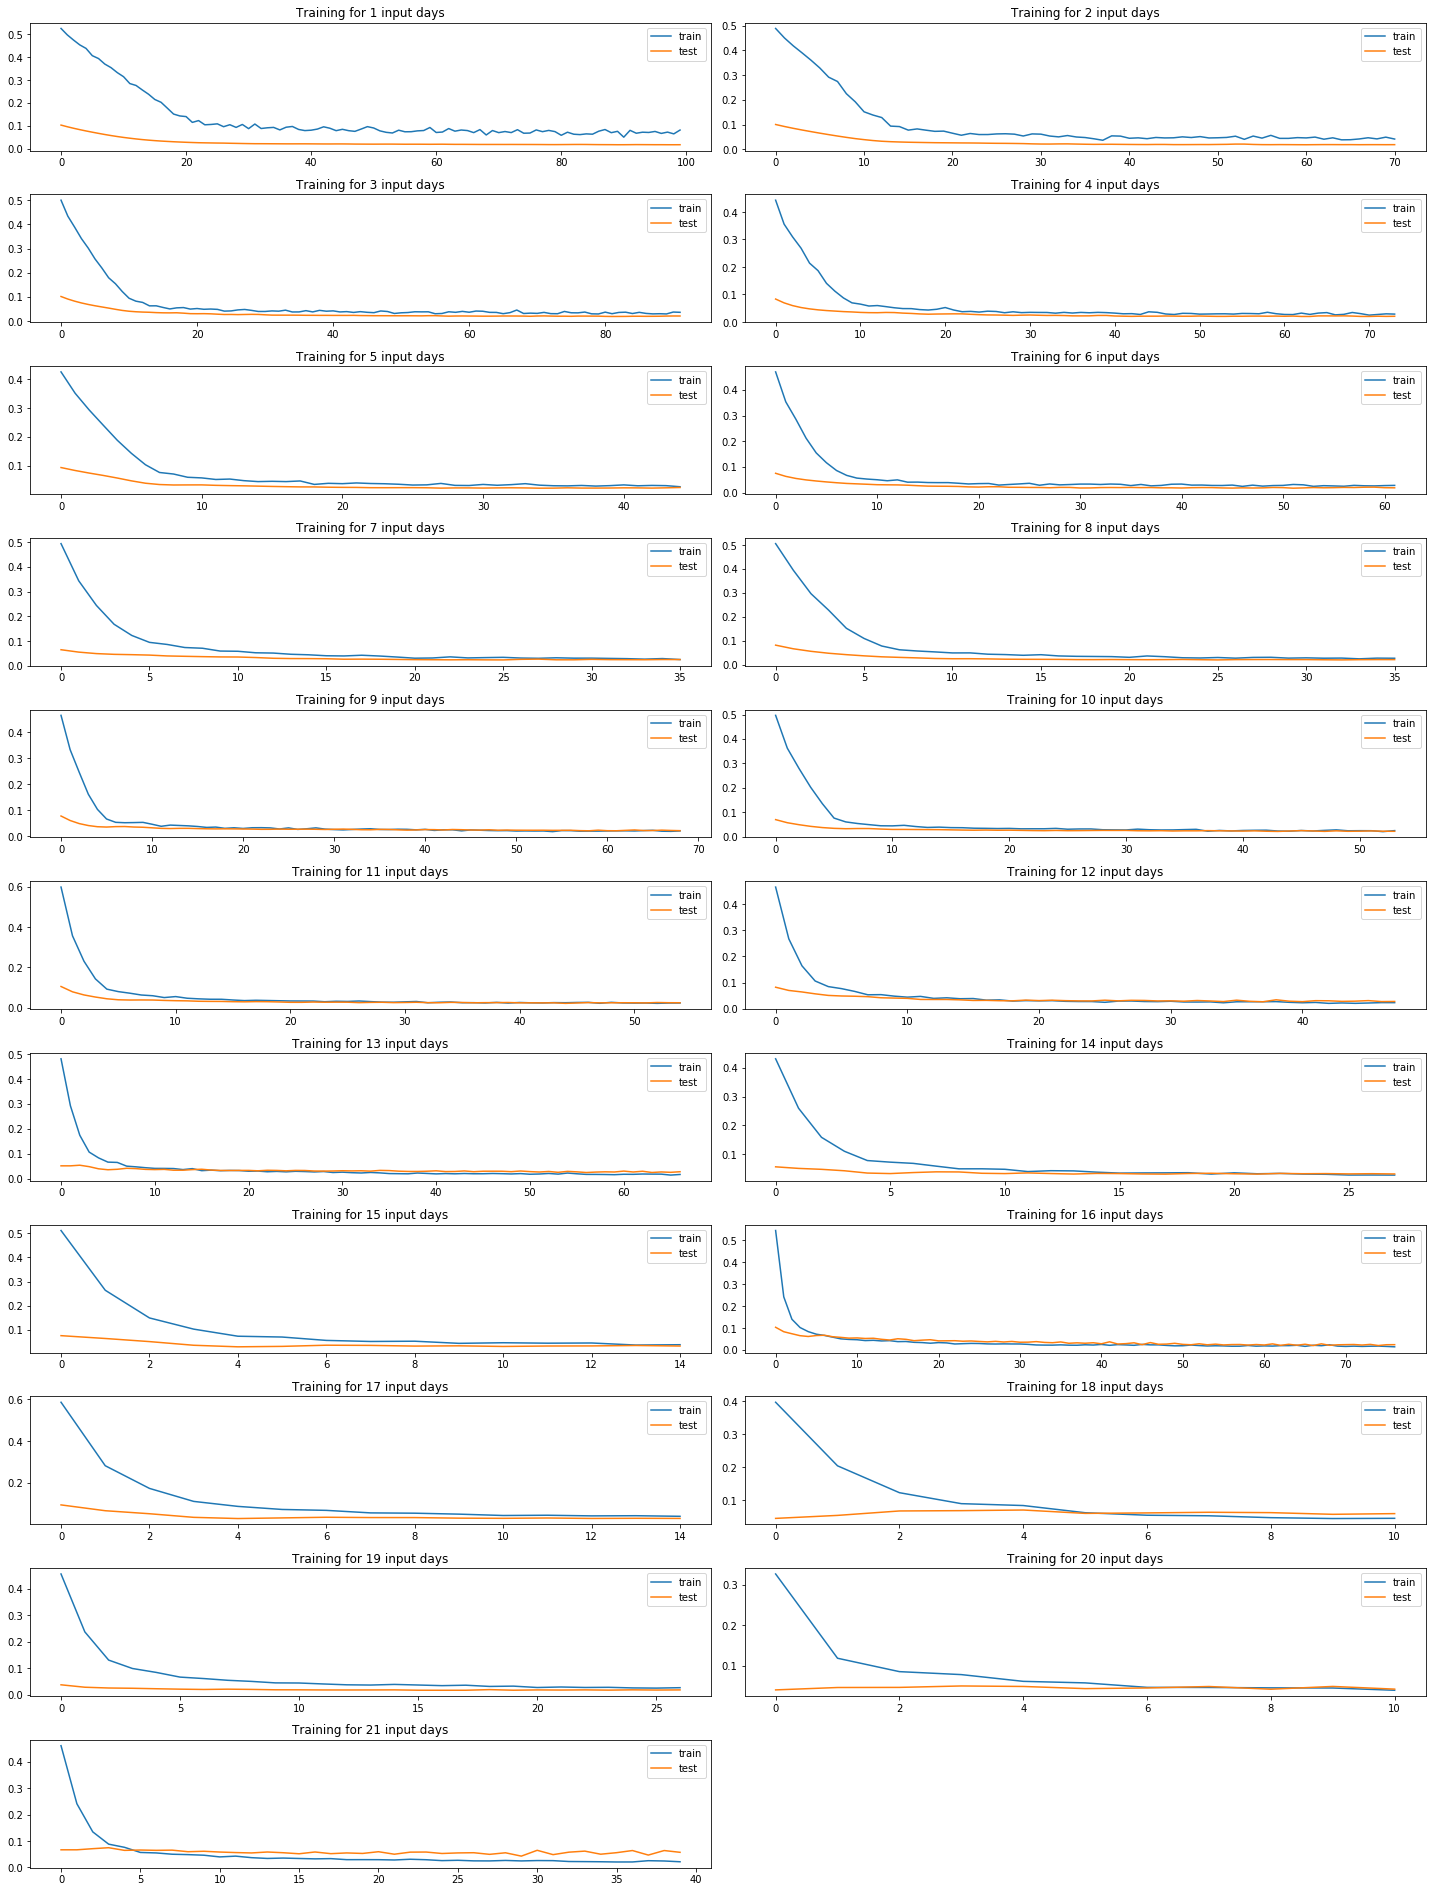

In [209]:
plots(histories)

In [210]:
cases_rmse = [x[0] for x in predictions]
deaths_rmse = [x[1] for x in predictions]

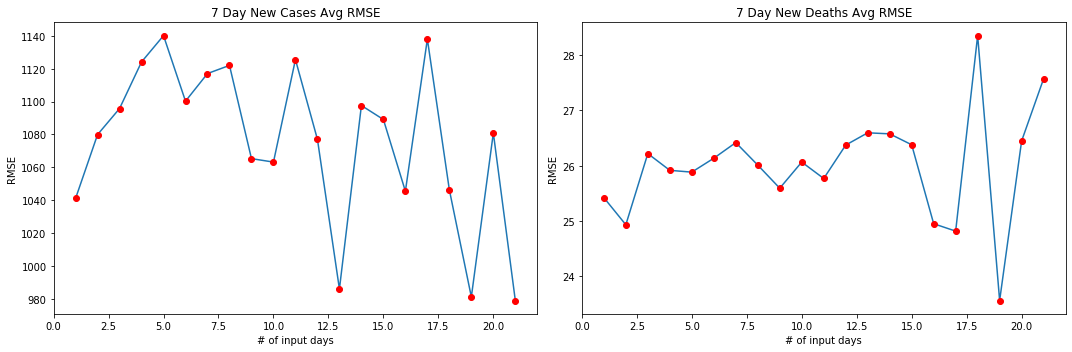

In [211]:
fig = plt.figure(figsize=(15,5))

for (i, rmse, title) in zip([1,2], [cases_rmse, deaths_rmse], ['7 Day New Cases Avg RMSE', '7 Day New Deaths Avg RMSE']):
    plt.subplot(1,2,i)
    plt.plot(range(1,len(predictions)+1),rmse)
    plt.plot(range(1,len(predictions)+1),rmse,'or')
    plt.title(title)
    plt.xlabel('# of input days')
    plt.ylabel('RMSE')
    
plt.tight_layout()
plt.show()